# Data Preprocessing

In [1]:
import pandas as pd
import PIL
from glob import glob
import os
import re
import random
import chitra
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from chitra.image import Chitra
from sklearn.model_selection import train_test_split

In [3]:

def load_data(typ):

    """Load image data and join with annotation information."""

    df_annotation = pd.read_csv(f"data/{typ}/_annotations.csv")
    df_img = pd.DataFrame()

    base_dir = rf'data/{typ}/*.jpg'
    files = glob(base_dir)

    imgs = []
    for i in files:
        imgs.append(plt.imread(i))

    files = [re.sub(f'data/{typ}/', '', i) for i in files]

    df_img['filename'] = files
    df_img['image'] = imgs
    df_train = pd.merge(df_annotation, df_img, on='filename')
    return df_train


In [ ]:
df_train = load_data('train')
#df_valid = load_data('valid')
#df_test = load_data('test')

print(df_train.info())
#print(df_valid.info())
#print(df_test.info())

In [ ]:
# write data to pickle:
#df_train.to_pickle('data/chess_new.pickle')

In [ ]:
# check ranges of bounding boxes
#df_train[['xmin', 'ymin', 'xmax', 'ymax']].agg(['max', 'min'])

In [ ]:
# Display sample image with annotation

sample_img = df_train.iloc[1111,:] #4801


figsize = sample_img['width'] / float(100), sample_img['height']/ float(100)
fig, ax = plt.subplots(figsize=figsize)
#new_width = sample_img['width'] / 6.4
#new_height = sample_img['height'] / 4.8

#ax.axis('off')
ax.imshow(sample_img['image'])
rect = patches.Rectangle((sample_img['xmin'], sample_img['ymin']), 
                         sample_img['xmax']-sample_img['xmin'], 
                         sample_img['ymax']-sample_img['ymin'],
                         edgecolor='red',
                         facecolor='none',
                         linewidth=3,
                         )

ax.add_patch(rect)
annot_height = sample_img['ymin'] + (sample_img['ymax']-sample_img['ymin']) + 20
ax.annotate(sample_img['class'], (sample_img['xmin'], annot_height), color='red',
            size=20)

Some annotations are incorrect (e.g. axes transposed). Manually check if annotations are correct in `check_annotations.ipynb`.

## Load checked data

In [ ]:
# Add togehther annotations
annot_1 = pd.read_csv('data/checked_annot/top_184_anot.csv')
annot_2 = pd.read_csv('data/checked_annot/bottom_annot.csv')
annot_3 = pd.read_csv('data/checked_annot/bottom_annot_1602_downwards.csv')

In [ ]:
# Concatenate sheets
annot_total = pd.concat([annot_1, annot_2, annot_3])
annot_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025 entries, 0 to 371
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1025 non-null   int64 
 1   filename      1025 non-null   object
 2   correct_anot  1015 non-null   object
dtypes: int64(1), object(2)
memory usage: 32.0+ KB


In [ ]:
# Filter for correctly annotated
annot_correct = annot_total[annot_total['correct_anot'] == 'y']

# get length of correctly annotated:
annot_img_list = list(annot_correct['filename'].unique())
print(len(annot_img_list))

In [ ]:
# get new dataset
chess_df = df_train[df_train['filename'].isin(annot_img_list)]
#print(chess_df.info())

# Check unique pictures
chess_df['filename'].nunique()

In [ ]:
# Write data to csv
#chess_df.to_pickle('data/chess_new.p')

## Resizing images

Given that `image` is a `Chitra` object:

* Get ndarray of image with `image.numpy()`
* Get resized bounding box xmin, ymin with `image.bboxes[0][0]`
* Get resized bounding box xmax, ymax with `image.bboxes[0][1]`
* Get resized bounding box label with `image.bboxes[0].label`

In [2]:
# laod data:
chess_df = pd.read_pickle('data/chess_new.p')

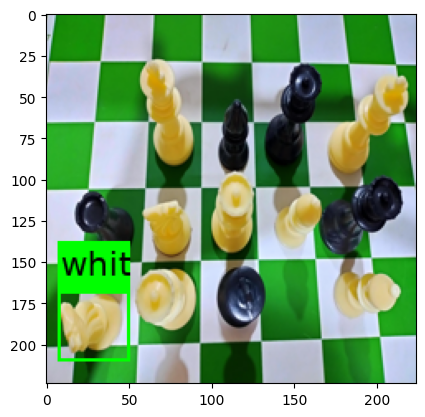

In [36]:
# display sample image with chitra:

import chitra
from chitra.image import Chitra

tryout = chess_df.iloc[7]

ymin = tryout['ymin']
ymax = tryout['ymax']
xmin = tryout['xmin']
xmax = tryout['xmax']

label = tryout['class']

bbox = [xmin, ymin, xmax, ymax]

filename = tryout['filename']

img_path = f'data/train/{filename}'
image = Chitra(img_path, bboxes=bbox, labels=label, box_format= 'BoundingBoxes.CORNER')
image.resize_image_with_bbox((224, 224))

figsize = tryout['width'] / float(100), tryout['height']/ float(100)

#plt.figure(figsize=figsize)
plt.imshow(image.draw_boxes())

In [ ]:
def resize_images(samp, resize = (224, 224)):
    
    """Function to convert one row of chess df to dictionary with resized information."""

    bbox = [samp['xmin'], samp['ymin'], samp['xmax'], samp['ymax']]
    
    filename = samp['filename']
    img_path = f'data/train/{filename}'
    
    image = Chitra(img_path, bboxes=bbox, labels=samp['class'], box_format='BoundingBoxes.CORNER')
    image.resize_image_with_bbox(resize)

    return {'filename': filename, 
            'width': image.shape[0], 
            'height': image.shape[1], 
            'class': image.bboxes[0].label, 
            'xmin': image.bboxes[0][0][0], 
            'ymin': image.bboxes[0][0][1], 
            'xmax' : image.bboxes[0][1][0], 
            'ymax': image.bboxes[0][1][1], 
            'image': image.numpy()}

In [ ]:
# Iterate through dataset and append resized images
df_chess_resized= pd.DataFrame()

for i in range(chess_df.shape[0]):
    
    df_add = pd.DataFrame.from_dict(resize_images(chess_df.iloc[i]), orient='index').T
    df_chess_resized = pd.concat([df_chess_resized, df_add], axis=0, ignore_index=True)

In [ ]:
#df_chess_resized.to_pickle('data/chess_resized.p')

## Data split

In [51]:
# load data
chess_resized_df = pd.read_pickle('data/chess_resized.p')

In [52]:
# get all filenames
list_filenames = chess_resized_df['filename'].unique()
#print(len(list_filenames))

# 0.8, 0.1, 0.1 train, val, test split 
train_files, rest_files = train_test_split(list_filenames, train_size=0.8, random_state=37, shuffle=True)
val_files, test_files = train_test_split(rest_files, train_size=0.5, random_state = 41, shuffle=True)

print(f'train file length: {len(train_files)}\nvalid file length: {len(val_files)}\ntest file length: {len(test_files)}')

train file length: 651
valid file length: 81
test file length: 82


In [53]:
# filter new dfs based on filename split 
chess_train_df = chess_resized_df[chess_resized_df['filename'].isin(train_files)]
chess_val_df = chess_resized_df[chess_resized_df['filename'].isin(val_files)]
chess_test_df = chess_resized_df[chess_resized_df['filename'].isin(test_files)]


# check if percentage is still correct since not all chess images have the same amount of bounding boxes (rows)
print(f'train length: {len(chess_train_df)}, percent: {round(len(chess_train_df)/chess_resized_df.shape[0], 2)}\n\
valid length: {len(chess_val_df)}, percent: {round(len(chess_val_df)/chess_resized_df.shape[0], 2)}\n\
test length: {len(chess_test_df)}, percent: {round(len(chess_test_df)/chess_resized_df.shape[0], 2)}')

train length: 9218, percent: 0.81
valid length: 1107, percent: 0.1
test length: 1125, percent: 0.1


In [54]:
# save files:
#chess_train_df.to_pickle('data/final_data/chess_train_df.p')
#chess_val_df.to_pickle('data/final_data/chess_val_df.p')
#chess_test_df.to_pickle('data/final_data/chess_test_df.p')